# **Install Libraries**

In [ ]:
!pip install opendatasets

# **Import Libraries**

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# **Download and Read Dataset**

In [ ]:
od.download("https://www.kaggle.com/datasets/rnunez1975/suicide-detection-clean")

Skipping, found downloaded files in "./suicide-detection-clean" (use force=True to force download)


In [ ]:
df= pd.read_csv("/content/suicide-detection-clean/Suicide_Detection_clean.csv")

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,class
0,0,2,ex wife threatening suiciderecently i left my ...,suicide
1,1,3,am i weird i dont get affected by compliments ...,non-suicide
2,2,4,finally 2020 is almost over so i can never hea...,non-suicide
3,3,8,i need helpjust help im crying so hard,suicide
4,4,9,im so losthello my name is adam 16 and ive bee...,suicide


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0.1  232074 non-null  int64 
 1   Unnamed: 0    232074 non-null  int64 
 2   text          232024 non-null  object
 3   class         232074 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.1+ MB


In [ ]:
df = df[['text', 'class']]

# **Handling Null values**

**Check for Null values**

In [ ]:
df.isnull().sum()

text     50
class     0
dtype: int64

**Delete Null values**

In [ ]:
df= df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232024 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232024 non-null  object
 1   class   232024 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


# **Data Selection**

**Randomly choose 13k data**

In [ ]:
# Randomly sample 13,000 rows
random_sample = df.sample(n=13000, random_state=42)  # Adjust random_state for reproducibility

In [ ]:
# Display the resulting DataFrame
print(random_sample)

                                                     text        class
79118   hey daily check up time good morning how are w...  non-suicide
24810   how bad would it be to test near everything fo...  non-suicide
92532   just got my first deathmessenger pm in my inbo...      suicide
63853   so some idiot complained to my manger telling ...  non-suicide
79510   just calculated my life expectancy and burst i...      suicide
...                                                   ...          ...
31711   once and lifetime opportunity to ask girl anyt...  non-suicide
206995     big flex i still dont have the infected tag on  non-suicide
19587   help i lost my airpods because of my big juicy...  non-suicide
38530   i live beyond the melancholywhat i mean is i l...      suicide
131505  i wish they hadnt found mei tried to kill myse...      suicide

[13000 rows x 2 columns]


**Reset the index of the Dataset**

In [ ]:
# reset index
df = random_sample.reset_index(drop=True)

In [ ]:
df.head()

,text,class
0,hey daily check up time good morning how are w...,non-suicide
1,how bad would it be to test near everything fo...,non-suicide
2,just got my first deathmessenger pm in my inbo...,suicide
3,so some idiot complained to my manger telling ...,non-suicide
4,just calculated my life expectancy and burst i...,suicide


# **Plot Class Count**

In [ ]:
# Set the overall style
sns.set(style="whitegrid")

# Customize the color palette
custom_palette = sns.color_palette("Set2", 8)
sns.set_palette(custom_palette)


<Axes: xlabel='class', ylabel='count'>

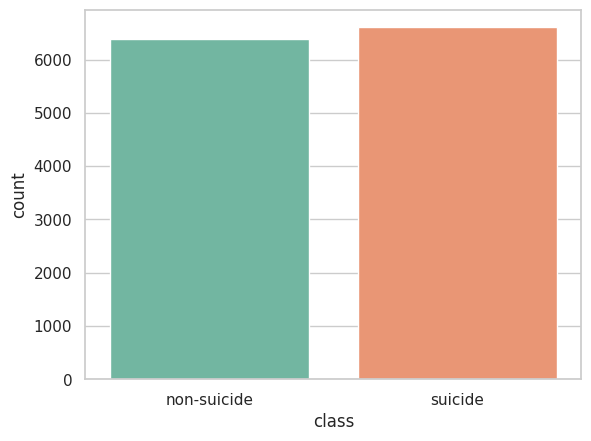

In [ ]:
#plotting the target col in count plot
sns.countplot(x='class', data=df)

In [ ]:
df.shape

(13000, 2)

# **Pre-processing**

**Seperate feature and target variables**

In [ ]:
x = df.text.values
y = df['class'].values

**Encode the target variable**

In [ ]:
# Use LabelEncoder to encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

**Split dataset for training and testing**

In [ ]:
RANDOM_STATE = 42

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

**Initialize Tokenizer and Tokenize text data**

In [ ]:
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)


**Fix vocabulary size and maximum length of the data**

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200

**Padding**

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**Convert data into pytorch Tensors**

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

**Define Data Loader**

In [ ]:
# Define DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **CNN**

**Model Architecture**

In [ ]:
# Define CNN architecture in PyTorch
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, maxlen):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.dense1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change the dimension for Conv1d
        x = self.conv1d(x)
        x = self.global_max_pooling(x).squeeze(2)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x

**Create an instance of the model**

In [ ]:
# Create an instance of the CNNModel
embedding_dim = 100
model = CNNModel(vocab_size, embedding_dim, maxlen)

**Define Loss and Optimizer**

In [ ]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Define Early Stopping Parameters**

In [ ]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

In [ ]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

**Train Machine**

Here, code for early stopping is included. But I commented it out as is does not give a better result for my data

In [ ]:
# Training loop with early stopping and model checkpoint
epochs = 10
history_cnn = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Evaluation on training set
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).squeeze().numpy()
        train_acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
        train_accuracies.append(train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        y_test_pred = model(X_test).squeeze().numpy()
        val_acc = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
        val_accuracies.append(val_acc)

        val_loss = criterion(torch.tensor(y_test_pred).view(-1, 1), y_test.view(-1, 1))
        val_losses.append(val_loss.item())

    # Record history values
    history_cnn['accuracy'].append(train_acc)
    history_cnn['val_accuracy'].append(val_acc)
    history_cnn['loss'].append(loss.item())
    history_cnn['val_loss'].append(val_loss.item())

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.item():.4f}')

    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     patience_counter = 0
    #     # Save the best model
    #     torch.save(model.state_dict(), 'best_model.pth')
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print("Early stopping. Restoring the best model.")
    #         model.load_state_dict(torch.load('best_model.pth'))
    #         break


Epoch 1/10, Loss: 0.2388, Train Acc: 0.9123, Val Acc: 0.8735, Val Loss: 0.3168
Epoch 2/10, Loss: 0.2262, Train Acc: 0.9787, Val Acc: 0.8804, Val Loss: 0.3013
Epoch 3/10, Loss: 0.2427, Train Acc: 0.9872, Val Acc: 0.8758, Val Loss: 0.3951
Epoch 4/10, Loss: 0.0036, Train Acc: 0.9963, Val Acc: 0.8819, Val Loss: 0.4422
Epoch 5/10, Loss: 0.0057, Train Acc: 0.9980, Val Acc: 0.8846, Val Loss: 0.5073
Epoch 6/10, Loss: 0.0035, Train Acc: 0.9994, Val Acc: 0.8850, Val Loss: 0.5970
Epoch 7/10, Loss: 0.0094, Train Acc: 0.9917, Val Acc: 0.8712, Val Loss: 0.7208
Epoch 8/10, Loss: 0.0041, Train Acc: 0.9909, Val Acc: 0.8788, Val Loss: 1.0630
Epoch 9/10, Loss: 0.0285, Train Acc: 0.9962, Val Acc: 0.8738, Val Loss: 0.9723
Epoch 10/10, Loss: 0.0760, Train Acc: 0.9997, Val Acc: 0.8904, Val Loss: 0.8913


**Evaluation on test data**

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).squeeze().numpy()
    y_test_pred = model(X_test).squeeze().numpy()

print("Training Accuracy: {:.4f}".format(accuracy_score(y_train, (y_train_pred > 0.5).astype(int))))
print("Testing Accuracy: {:.4f}".format(accuracy_score(y_test, (y_test_pred > 0.5).astype(int))))

Training Accuracy: 0.9998
Testing Accuracy: 0.8754


**Confusion Matrix**

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)

    # Display the actual values in each box
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')


In [ ]:
# Class labels for the confusion matrix
class_labels = ['Non Suicide', 'Suicide']

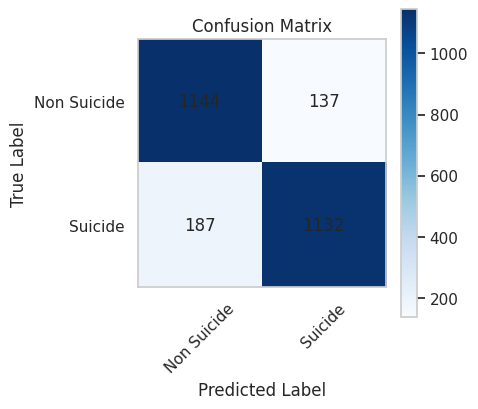

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
plot_confusion_matrix(y_test, (y_test_pred > 0.5).astype(int), classes=class_labels)
plt.show()

**Classification Report**

In [ ]:
# Plot Classification Report
print("Classification Report:\n", classification_report(y_test, (y_test_pred > 0.5).astype(int), target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

 Non Suicide       0.86      0.89      0.88      1281
     Suicide       0.89      0.86      0.87      1319

    accuracy                           0.88      2600
   macro avg       0.88      0.88      0.88      2600
weighted avg       0.88      0.88      0.88      2600



**Train-Validation Accuracy Loss Curve**

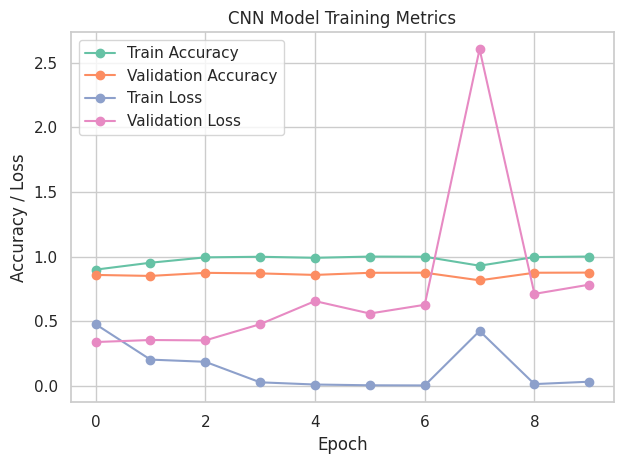

In [ ]:
# Plot Accuracy
plt.plot(history_cnn['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_cnn['val_accuracy'], marker='o', label='Validation Accuracy')

# Plot Loss
plt.plot(history_cnn['loss'], marker='o', label='Train Loss')
plt.plot(history_cnn['val_loss'], marker='o', label='Validation Loss')

# Set appropriate title and labels
plt.title('CNN Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.tight_layout()
plt.show()

**Model Summary**

In [ ]:
# Model Summary and Parameters
print("Model Summary:")
print(model)
print("\nModel Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")


Model Summary:
CNNModel(
  (embedding): Embedding(38791, 100)
  (conv1d): Conv1d(100, 128, kernel_size=(5,), stride=(1,))
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (dense1): Linear(in_features=128, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Parameters:
embedding.weight: 3879100 parameters
conv1d.weight: 64000 parameters
conv1d.bias: 128 parameters
dense1.weight: 32768 parameters
dense1.bias: 256 parameters
dense2.weight: 256 parameters
dense2.bias: 1 parameters


# **RNN**

**Model Architecture**

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, maxlen):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.dense1 = nn.Linear(hidden_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hn = self.rnn(x)
        x = hn.squeeze(0)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x


**Create an instance of the model and Define Loss and Optimizer**

In [ ]:
# Create an instance of the RNNModel
rnn_model = RNNModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=128, maxlen=maxlen)

# Loss and optimizer
rnn_criterion = nn.BCELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)


**Train Machine**

In [ ]:
epochs = 10
history_rnn = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
# best_val_loss = float('inf')
# patience_counter = 0


for epoch in range(epochs):
    rnn_model.train()
    for inputs, labels in train_loader:
        rnn_optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = rnn_criterion(outputs, labels.view(-1, 1))
        loss.backward()
        rnn_optimizer.step()

    # Evaluation on training set
    rnn_model.eval()
    with torch.no_grad():
        y_train_pred = rnn_model(X_train).squeeze().numpy()
        train_acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
        train_accuracies.append(train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        y_test_pred = rnn_model(X_test).squeeze().numpy()
        val_acc = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
        val_accuracies.append(val_acc)

        val_loss = rnn_criterion(torch.tensor(y_test_pred).view(-1, 1), y_test.view(-1, 1))
        val_losses.append(val_loss.item())

    # Record history values
    history_rnn['accuracy'].append(train_acc)
    history_rnn['val_accuracy'].append(val_acc)
    history_rnn['loss'].append(loss.item())
    history_rnn['val_loss'].append(val_loss.item())

    print(f'RNN - Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.item():.4f}')


RNN - Epoch 1/10, Loss: 0.5202, Train Acc: 0.6309, Val Acc: 0.6250, Val Loss: 0.6329
RNN - Epoch 2/10, Loss: 0.6446, Train Acc: 0.6322, Val Acc: 0.6254, Val Loss: 0.6303
RNN - Epoch 3/10, Loss: 0.5783, Train Acc: 0.5129, Val Acc: 0.5058, Val Loss: 0.6528
RNN - Epoch 4/10, Loss: 0.5619, Train Acc: 0.6392, Val Acc: 0.6250, Val Loss: 0.6422
RNN - Epoch 5/10, Loss: 0.7125, Train Acc: 0.6432, Val Acc: 0.6242, Val Loss: 0.6363
RNN - Epoch 6/10, Loss: 0.5687, Train Acc: 0.5230, Val Acc: 0.5031, Val Loss: 0.6627
RNN - Epoch 7/10, Loss: 0.4957, Train Acc: 0.6493, Val Acc: 0.6165, Val Loss: 0.6498
RNN - Epoch 8/10, Loss: 0.6275, Train Acc: 0.6522, Val Acc: 0.6112, Val Loss: 0.6809
RNN - Epoch 9/10, Loss: 0.4960, Train Acc: 0.6532, Val Acc: 0.6150, Val Loss: 0.6781
RNN - Epoch 10/10, Loss: 0.5419, Train Acc: 0.6546, Val Acc: 0.6092, Val Loss: 0.7048


**Confusion Matrix**


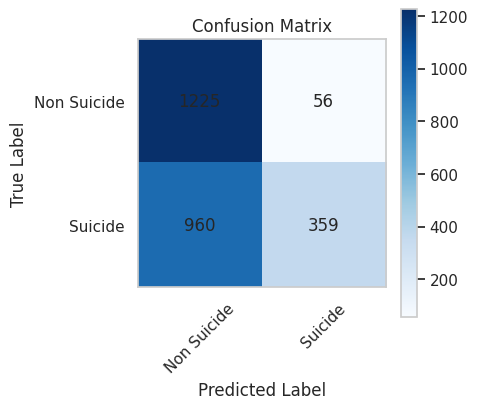

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
plot_confusion_matrix(y_test, (y_test_pred > 0.5).astype(int), classes=class_labels)
plt.show()

**Classification Report**


In [ ]:
# Plot Classification Report
print("Classification Report:\n", classification_report(y_test, (y_test_pred > 0.5).astype(int), target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

 Non Suicide       0.56      0.96      0.71      1281
     Suicide       0.87      0.27      0.41      1319

    accuracy                           0.61      2600
   macro avg       0.71      0.61      0.56      2600
weighted avg       0.72      0.61      0.56      2600



**Train-Validation Accuracy Loss Curve**

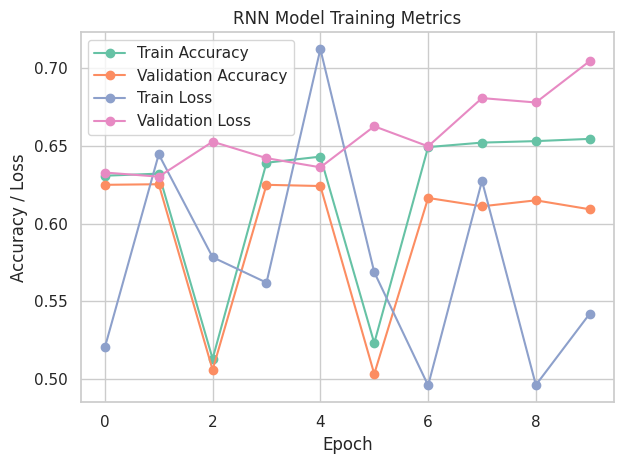

In [ ]:
# Plot Accuracy
plt.plot(history_rnn['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_rnn['val_accuracy'], marker='o', label='Validation Accuracy')

# Plot Loss
plt.plot(history_rnn['loss'], marker='o', label='Train Loss')
plt.plot(history_rnn['val_loss'], marker='o', label='Validation Loss')

# Set appropriate title and labels
plt.title('RNN Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.tight_layout()
plt.show()

# **LSTM**

**Model Architecture**


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, maxlen):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        x = hn.squeeze(0)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


**Create an instance of the model and Define Loss and Optimizer**


In [ ]:
# Create an instance of the LSTMModel
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=128, maxlen=maxlen)

# Loss and optimizer
lstm_criterion = nn.BCELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


**Train Machine**

In [ ]:
epochs = 10
history_lstm = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(epochs):
    lstm_model.train()
    for inputs, labels in train_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = lstm_criterion(outputs, labels.view(-1, 1))
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1)

        lstm_optimizer.step()

    # Evaluation on training set
    lstm_model.eval()
    with torch.no_grad():
        y_train_pred = lstm_model(X_train).squeeze().numpy()
        train_acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
        history_lstm['accuracy'].append(train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        y_test_pred = lstm_model(X_test).squeeze().numpy()
        val_acc = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
        val_loss = lstm_criterion(torch.tensor(y_test_pred).view(-1, 1), y_test.view(-1, 1))

        history_lstm['val_accuracy'].append(val_acc)
        history_lstm['loss'].append(loss.item())
        history_lstm['val_loss'].append(val_loss.item())

    print(f'LSTM - Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.item():.4f}')

LSTM - Epoch 1/10, Loss: 0.6025, Train Acc: 0.6331, Val Acc: 0.6269, Val Loss: 0.6274
LSTM - Epoch 2/10, Loss: 0.5007, Train Acc: 0.8520, Val Acc: 0.8235, Val Loss: 0.4164
LSTM - Epoch 3/10, Loss: 0.3527, Train Acc: 0.9163, Val Acc: 0.8719, Val Loss: 0.3304
LSTM - Epoch 4/10, Loss: 0.1461, Train Acc: 0.9420, Val Acc: 0.8754, Val Loss: 0.3241
LSTM - Epoch 5/10, Loss: 0.1836, Train Acc: 0.9629, Val Acc: 0.8650, Val Loss: 0.3874
LSTM - Epoch 6/10, Loss: 0.1381, Train Acc: 0.9761, Val Acc: 0.8708, Val Loss: 0.3995
LSTM - Epoch 7/10, Loss: 0.0136, Train Acc: 0.9818, Val Acc: 0.8762, Val Loss: 0.4956
LSTM - Epoch 8/10, Loss: 0.0175, Train Acc: 0.9912, Val Acc: 0.8804, Val Loss: 0.5543
LSTM - Epoch 9/10, Loss: 0.1945, Train Acc: 0.9932, Val Acc: 0.8735, Val Loss: 0.6476
LSTM - Epoch 10/10, Loss: 0.0046, Train Acc: 0.9955, Val Acc: 0.8800, Val Loss: 0.7616



**Confusion Matrix**


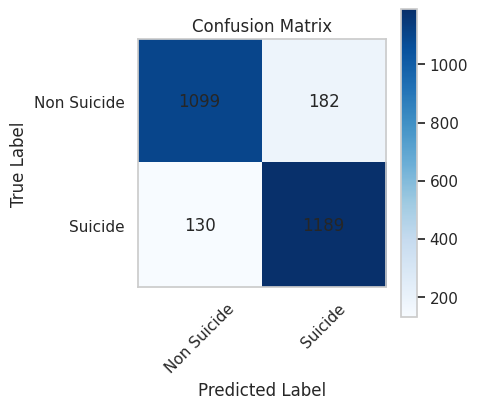

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
plot_confusion_matrix(y_test, (y_test_pred > 0.5).astype(int), classes=class_labels)
plt.show()

**Classification Report**

In [ ]:
# Plot Classification Report
print("Classification Report:\n", classification_report(y_test, (y_test_pred > 0.5).astype(int), target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

 Non Suicide       0.89      0.86      0.88      1281
     Suicide       0.87      0.90      0.88      1319

    accuracy                           0.88      2600
   macro avg       0.88      0.88      0.88      2600
weighted avg       0.88      0.88      0.88      2600



**Train-Validation Accuracy Loss Curve**

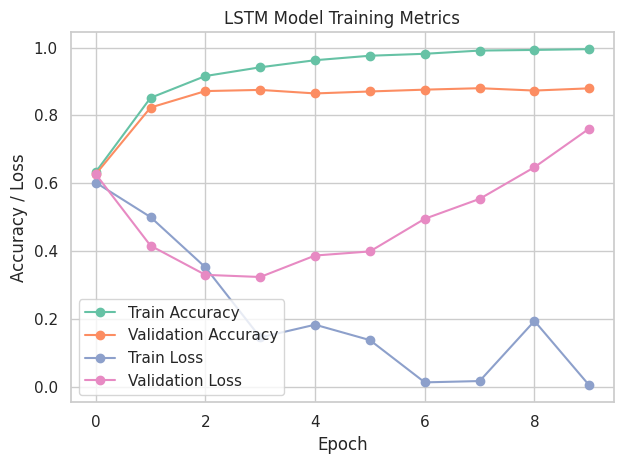

In [ ]:
# Plot Accuracy
plt.plot(history_lstm['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_lstm['val_accuracy'], marker='o', label='Validation Accuracy')

# Plot Loss
plt.plot(history_lstm['loss'], marker='o', label='Train Loss')
plt.plot(history_lstm['val_loss'], marker='o', label='Validation Loss')

# Set appropriate title and labels
plt.title('LSTM Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.tight_layout()
plt.show()

# **Bi-LSTM**

**Model Architecture**

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, maxlen):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # multiplied by 2 for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.bilstm(x)
        x = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)  # concatenate hidden states from both directions
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x



**Create an instance of the model and Define Loss and Optimizer**


In [ ]:
# Create an instance of the BiLSTMModel
bilstm_model = BiLSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=128, maxlen=maxlen)

# Loss and optimizer
bilstm_criterion = nn.BCELoss()
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)


**Train Machine**


In [ ]:
epochs = 10
history_bilstm = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(epochs):
    bilstm_model.train()
    for inputs, labels in train_loader:
        bilstm_optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = bilstm_criterion(outputs, labels.view(-1, 1))
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1)

        bilstm_optimizer.step()

    # Evaluation on training set
    bilstm_model.eval()
    with torch.no_grad():
        y_train_pred = bilstm_model(X_train).squeeze().numpy()
        train_acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
        history_bilstm['accuracy'].append(train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        y_test_pred = bilstm_model(X_test).squeeze().numpy()
        val_acc = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
        val_loss = bilstm_criterion(torch.tensor(y_test_pred).view(-1, 1), y_test.view(-1, 1))

        history_bilstm['val_accuracy'].append(val_acc)
        history_bilstm['loss'].append(loss.item())
        history_bilstm['val_loss'].append(val_loss.item())

    print(f'Bi-LSTM - Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.item():.4f}')

Bi-LSTM - Epoch 1/10, Loss: 0.4790, Train Acc: 0.8736, Val Acc: 0.8538, Val Loss: 0.3560
Bi-LSTM - Epoch 2/10, Loss: 0.3706, Train Acc: 0.9217, Val Acc: 0.8815, Val Loss: 0.2954
Bi-LSTM - Epoch 3/10, Loss: 0.1797, Train Acc: 0.9490, Val Acc: 0.8788, Val Loss: 0.2986
Bi-LSTM - Epoch 4/10, Loss: 0.1505, Train Acc: 0.9757, Val Acc: 0.8904, Val Loss: 0.3259
Bi-LSTM - Epoch 5/10, Loss: 0.0144, Train Acc: 0.9881, Val Acc: 0.8969, Val Loss: 0.3957
Bi-LSTM - Epoch 6/10, Loss: 0.1265, Train Acc: 0.9895, Val Acc: 0.8935, Val Loss: 0.6630
Bi-LSTM - Epoch 7/10, Loss: 0.0262, Train Acc: 0.9912, Val Acc: 0.8754, Val Loss: 0.7203
Bi-LSTM - Epoch 8/10, Loss: 0.0126, Train Acc: 0.9938, Val Acc: 0.8712, Val Loss: 0.8996
Bi-LSTM - Epoch 9/10, Loss: 0.0030, Train Acc: 0.9977, Val Acc: 0.8785, Val Loss: 0.9811
Bi-LSTM - Epoch 10/10, Loss: 0.0001, Train Acc: 0.9974, Val Acc: 0.8923, Val Loss: 1.7725


**Confusion Matrix**


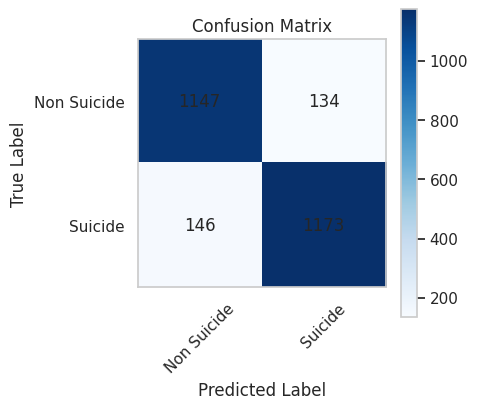

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
plot_confusion_matrix(y_test, (y_test_pred > 0.5).astype(int), classes=class_labels)
plt.show()

**Classification Report**


In [ ]:
# Plot Classification Report
print("Classification Report:\n", classification_report(y_test, (y_test_pred > 0.5).astype(int), target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

 Non Suicide       0.89      0.90      0.89      1281
     Suicide       0.90      0.89      0.89      1319

    accuracy                           0.89      2600
   macro avg       0.89      0.89      0.89      2600
weighted avg       0.89      0.89      0.89      2600



**Train-Validation Accuracy Loss Curve**

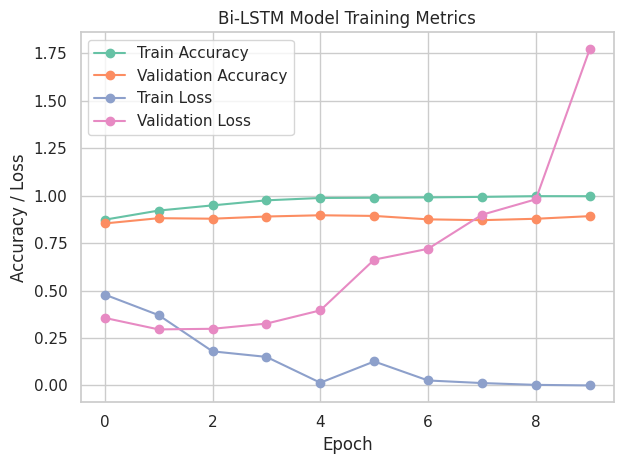

In [ ]:
# Plot Accuracy
plt.plot(history_bilstm['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_bilstm['val_accuracy'], marker='o', label='Validation Accuracy')

# Plot Loss
plt.plot(history_bilstm['loss'], marker='o', label='Train Loss')
plt.plot(history_bilstm['val_loss'], marker='o', label='Validation Loss')

# Set appropriate title and labels
plt.title('Bi-LSTM Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.tight_layout()
plt.show()

# **GRU**

**Model Architecture**


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, maxlen):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hn = self.gru(x)
        x = hn.squeeze(0)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


**Create an instance of the model and Define Loss and Optimizer**


In [ ]:
# Create an instance of the GRUModel
gru_model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=128, maxlen=maxlen)

# Loss and optimizer
gru_criterion = nn.BCELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)


**Train Machine**

In [ ]:
epochs = 10
history_gru = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(epochs):
    gru_model.train()
    for inputs, labels in train_loader:
        gru_optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = gru_criterion(outputs, labels.view(-1, 1))
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1)

        gru_optimizer.step()

    # Evaluation on training set
    gru_model.eval()
    with torch.no_grad():
        y_train_pred = gru_model(X_train).squeeze().numpy()
        train_acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
        history_gru['accuracy'].append(train_acc)

    # Evaluation on validation set
    with torch.no_grad():
        y_test_pred = gru_model(X_test).squeeze().numpy()
        val_acc = accuracy_score(y_test, (y_test_pred > 0.5).astype(int))
        val_loss = gru_criterion(torch.tensor(y_test_pred).view(-1, 1), y_test.view(-1, 1))

        history_gru['val_accuracy'].append(val_acc)
        history_gru['loss'].append(loss.item())
        history_gru['val_loss'].append(val_loss.item())

    print(f'GRU - Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss.item():.4f}')

GRU - Epoch 1/10, Loss: 0.3511, Train Acc: 0.8675, Val Acc: 0.8654, Val Loss: 0.3551
GRU - Epoch 2/10, Loss: 0.3095, Train Acc: 0.9214, Val Acc: 0.8808, Val Loss: 0.2842
GRU - Epoch 3/10, Loss: 0.1222, Train Acc: 0.9516, Val Acc: 0.8985, Val Loss: 0.2663
GRU - Epoch 4/10, Loss: 0.3380, Train Acc: 0.9734, Val Acc: 0.8981, Val Loss: 0.2817
GRU - Epoch 5/10, Loss: 0.0785, Train Acc: 0.9886, Val Acc: 0.8988, Val Loss: 0.3397
GRU - Epoch 6/10, Loss: 0.0464, Train Acc: 0.9946, Val Acc: 0.8954, Val Loss: 0.3590
GRU - Epoch 7/10, Loss: 0.2261, Train Acc: 0.9970, Val Acc: 0.8919, Val Loss: 0.4360
GRU - Epoch 8/10, Loss: 0.0001, Train Acc: 0.9965, Val Acc: 0.8877, Val Loss: 0.7023
GRU - Epoch 9/10, Loss: 0.0943, Train Acc: 0.9993, Val Acc: 0.8942, Val Loss: 0.5943
GRU - Epoch 10/10, Loss: 0.0001, Train Acc: 0.9994, Val Acc: 0.8888, Val Loss: 0.7232



**Confusion Matrix**

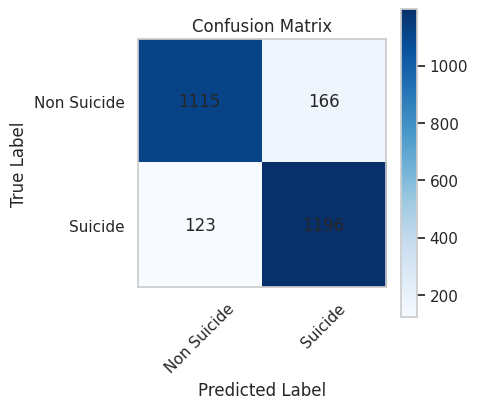

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
plot_confusion_matrix(y_test, (y_test_pred > 0.5).astype(int), classes=class_labels)
plt.show()


**Classification Report**


In [ ]:
# Plot Classification Report
print("Classification Report:\n", classification_report(y_test, (y_test_pred > 0.5).astype(int), target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

 Non Suicide       0.90      0.87      0.89      1281
     Suicide       0.88      0.91      0.89      1319

    accuracy                           0.89      2600
   macro avg       0.89      0.89      0.89      2600
weighted avg       0.89      0.89      0.89      2600



**Train-Validation Accuracy Loss Curve**

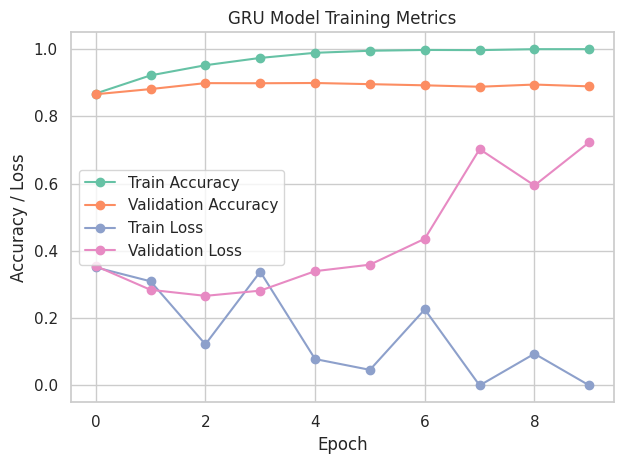

In [ ]:
# Plot Accuracy
plt.plot(history_gru['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_gru['val_accuracy'], marker='o', label='Validation Accuracy')

# Plot Loss
plt.plot(history_gru['loss'], marker='o', label='Train Loss')
plt.plot(history_gru['val_loss'], marker='o', label='Validation Loss')

# Set appropriate title and labels
plt.title('GRU Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.tight_layout()
plt.show()